Free subduction experiment in which a linear viscous slab sinks into a linear viscous mantle. The upper boundary condition is either free slip (left) or free surface (right). Clearly, the upper boundary condition has a significant effect on subduction dynamics, and only the free surface case is consistent with results of laboratory experiments. The average time step for the free surface case is significantly smaller than for the free surface case. Model parameters employed are: the slab has a density of?=3250kg/m3 and a viscosity of ?=1023 Pa s, whereas the mantle has ?=3200kg/m3, ?=1020 Pa s, the initial slab was 50km thick, 1500km long, and has a 125km long notch that initially subducted with an angle of 34◦. Free slip conditions are applied on the lower and side boundaries, and gravitational acceleration was 9.81 m/s2.
of∼800,000

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /opt/venv/lib/python3.9/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


## Scaling

In [2]:
u = GEO.UnitRegistry
half_rate = 1.0 * u.centimeter / u.year
model_length = 2000 * u.km
bodyforce = 3200 * u.kg / u.m**3 * 9.81 * u.m / u.s**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

## Model Geometry

In [3]:
gravity_vector = (0.0, -9.81 * u.m / u.s**2)
Model = GEO.Model(elementRes=(128, 32), 
                  elementType="Q2/dPc1",
                  minCoord=(0. * u.km, -600. * u.km), 
                  maxCoord=(2000. * u.km, 0. * u.km), 
                  gravity=gravity_vector)
Model.outputDir="outputs_Kaus2010_FS_FreeSlip"

	Global element size: 128x32
	Local offset of rank 0: 0x0
	Local range of rank 0: 128x32


In [4]:
import underworld.function as fn
import numpy as np

In [5]:
angle = 34.0 * u.degree
dx1 = np.cos(angle) * 125. * u.kilometer
dy1 = np.sin(angle) * 125. * u.kilometer 
dx2 = np.sin(angle) * 50. * u.kilometer
dy2 = np.cos(angle) * 50. * u.kilometer

polygon1 = GEO.shapes.Polygon([(500. * u.kilometer, 0. * u.kilometer),
                              (500. * u.kilometer - dx1, 0. * u.kilometer - dy1),
                              (500. * u.kilometer - dx1 + dx2, 0. * u.kilometer - dy1 - dy2),
                              (500. * u.kilometer + dx2, 0. * u.kilometer - dy2)])

polygon2 = GEO.shapes.Polygon([(500. * u.kilometer, 0. * u.kilometer),
                              (500. * u.kilometer, -50. * u.kilometer),
                              (2000. * u.kilometer , -50. * u.kilometer),
                              (2000. * u.kilometer, 0. * u.kilometer)])

polygon = polygon1 | polygon2

In [6]:
stickyAir = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer))
Mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=0.*u.kilometer, bottom=Model.bottom))
Lithosphere = Model.add_material(name="Lithosphere", shape=polygon)


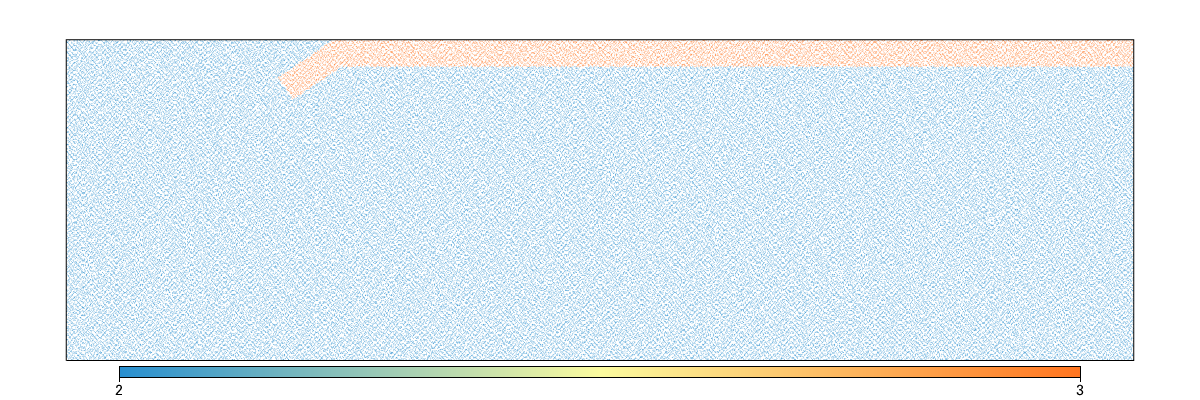

In [7]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField)
Fig.show()

In [8]:
x1, y1 = GEO.nd(500. * u.km - dx1), GEO.nd(-dy1)
x2, y2 = GEO.nd(500. * u.km - dx1 + dx2/2.0), GEO.nd(-dy1 - dy2/2.0)
x3, y3 = GEO.nd(500. * u.km - dx1 + dx2), GEO.nd(-dy1 - dy2)

coords = np.ndarray((3, 2))
coords[:, 0] = np.array([x1, x2, x3])
coords[:, 1] = np.array([y1, y2, y3])

Model.add_passive_tracers(name="tip", vertices=coords)


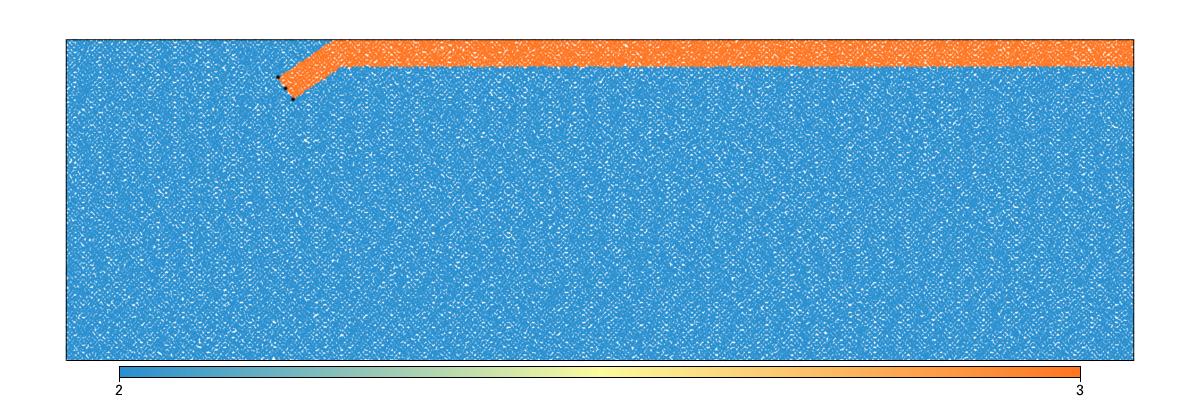

In [9]:
from UWGeodynamics import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.tip_tracers, pointSize=5.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig.show()

In [10]:
Mantle.viscosity = 1e20 * u.pascal * u.second
Lithosphere.viscosity = 1e23 * u.pascal * u.second

Mantle.density = 3200. * u.kilogram / u.metre**3
Lithosphere.density = 3250. * u.kilogram / u.metre**3

In [11]:
Model.set_velocityBCs(left=[0., None],
                      right=[0., None],
                      bottom=[None, 0.],
                      top=[None, 0.],
                      order_wall_conditions=[ "top", "left", "right", "bottom"])

In [12]:
#Model.freeSurface = True
#Model.fssa_factor = 1.0

In [13]:
Model.init_model(pressure="lithostatic")

/opt/venv/lib/python3.9/site-packages/UWGeodynamics/_model.py:1566: UserWarning: Skipping the steady state calculation: No diffusivity variable defined on Model
  warnings.warn("Skipping the steady state calculation: No diffusivity variable defined on Model")


In [14]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

outputss=['pressureField',
         'strainRateField',
         'velocityField',
          'projTimeField',
           'projMaterialField',
         'projViscosityField',
         'projStressField',
         'projDensityField',
         'projStressTensor',]
GEO.rcParams['default.outputs']=outputss

In [15]:
#Model.run_for(nstep=588, checkpoint_interval=1, dt=500000*u.year)
Model.run_for(294.0 * u.megayears, checkpoint_interval=2.0 * u.megayears,dt=500000*u.year)

Running with UWGeodynamics version 2.12.1
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.035881 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03183 secs / 1 its
  Pressure Solve:         = 0.1203 secs / 5 its
  Final V Solve:          = 0.02291 secs / 1 its

  Total BSSCR Linear solve time: 0.931236 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 9.330735e-01 (secs)
Time Integration
	2nd order: 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.036391 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02991 secs / 1 its
  Pressure Solve:         = 0.2172 secs / 5 its
  Final V Solve:          = 0.02476 secs / 1 its

  Total BSSCR Linear solve time: 0.853317 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.548380e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2062 [min] /    0.2062 [max] (secs)
Time Integration - 0.206243 [min] / 0.206243 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.7786e-05 [min] / 4.7786e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Step:    14 Model Time: 6.0 megayear dt: 0.0 second (2022-02-06 14:05:17)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.051518 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02352 secs / 1 its
  Pressure Solve:         = 0.1816 secs / 5 its
  Final V Solve:          = 0.02231 secs / 1 its

  Total BSSCR Linear solve time: 0.831044 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.342893e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1466 [min] /    0.1466 [max] (secs)
Time Integration - 0.146677 [min] / 0.146677 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.1389e-05 [min] / 5.1389e-05 [max] (secs)
In func WeightsCalculator_CalculateAll

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037967 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04753 secs / 1 its
  Pressure Solve:         = 0.1398 secs / 5 its
  Final V Solve:          = 0.02551 secs / 1 its

  Total BSSCR Linear solve time: 0.810871 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.122619e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1555 [min] /    0.1555 [max] (secs)
Time Integration - 0.155547 [min] / 0.155547 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.3735e-05 [min] / 4.3735e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.035920 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02404 secs / 1 its
  Pressure Solve:         = 0.1293 secs / 5 its
  Final V Solve:          = 0.02467 secs / 1 its

  Total BSSCR Linear solve time: 0.644712 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.464243e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1557 [min] /    0.1557 [max] (secs)
Time Integration - 0.155755 [min] / 0.155755 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.8742e-05 [min] / 3.8742e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.048363 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0537 secs / 1 its
  Pressure Solve:         = 0.1676 secs / 5 its
  Final V Solve:          = 0.02466 secs / 1 its

  Total BSSCR Linear solve time: 1.075632 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.078867e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1545 [min] /    0.1545 [max] (secs)
Time Integration - 0.154543 [min] / 0.154543 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.8227e-05 [min] / 4.8227e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Step:    42 Model Time: 20.0 megayear dt: 500000.0 year (2022-02-06 14:06:44)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.041787 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02413 secs / 1 its
  Pressure Solve:         = 0.2166 secs / 5 its
  Final V Solve:          = 0.04937 secs / 1 its

  Total BSSCR Linear solve time: 0.952013 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 9.535153e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1577 [min] /    0.1577 [max] (secs)
Time Integration - 0.157751 [min] / 0.157751 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.9643e-05 [min] / 5.9643e-05 [max] (secs)
In func WeightsCalculator_Calculat

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.038338 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02376 secs / 1 its
  Pressure Solve:         = 0.1382 secs / 5 its
  Final V Solve:          = 0.02263 secs / 1 its

  Total BSSCR Linear solve time: 0.674318 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.759400e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1786 [min] /    0.1786 [max] (secs)
Time Integration - 0.178636 [min] / 0.178636 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.2042e-05 [min] / 4.2042e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.038861 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02355 secs / 1 its
  Pressure Solve:         = 0.1352 secs / 5 its
  Final V Solve:          = 0.03001 secs / 1 its

  Total BSSCR Linear solve time: 0.659410 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.611009e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1526 [min] /    0.1526 [max] (secs)
Time Integration - 0.152646 [min] / 0.152646 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.8498e-05 [min] / 4.8498e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.035493 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02297 secs / 1 its
  Pressure Solve:         = 0.2299 secs / 5 its
  Final V Solve:          = 0.04254 secs / 1 its

  Total BSSCR Linear solve time: 0.764856 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.663307e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1600 [min] /    0.1600 [max] (secs)
Time Integration - 0.160033 [min] / 0.160033 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.5801e-05 [min] / 3.5801e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Step:    70 Model Time: 34.0 megayear dt: 500000.0 year (2022-02-06 14:08:15)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037343 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02495 secs / 1 its
  Pressure Solve:         = 0.1846 secs / 5 its
  Final V Solve:          = 0.04896 secs / 1 its

  Total BSSCR Linear solve time: 0.779030 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.823256e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1612 [min] /    0.1612 [max] (secs)
Time Integration - 0.161291 [min] / 0.161291 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.0466e-05 [min] / 5.0466e-05 [max] (secs)
In func WeightsCalculator_Calculat

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.058703 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04465 secs / 1 its
  Pressure Solve:         = 0.1863 secs / 5 its
  Final V Solve:          = 0.03079 secs / 1 its

  Total BSSCR Linear solve time: 1.165282 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.167902e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1564 [min] /    0.1564 [max] (secs)
Time Integration - 0.1564 [min] / 0.1564 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.6931e-05 [min] / 4.6931e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 cell

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037918 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02365 secs / 1 its
  Pressure Solve:         = 0.1543 secs / 5 its
  Final V Solve:          = 0.04867 secs / 1 its

  Total BSSCR Linear solve time: 0.869410 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.708969e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1619 [min] /    0.1619 [max] (secs)
Time Integration - 0.161949 [min] / 0.161949 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 6.529e-05 [min] / 6.529e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037134 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02339 secs / 1 its
  Pressure Solve:         = 0.1467 secs / 5 its
  Final V Solve:          = 0.04074 secs / 1 its

  Total BSSCR Linear solve time: 0.687931 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.895862e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1573 [min] /    0.1573 [max] (secs)
Time Integration - 0.15733 [min] / 0.15733 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.4939e-05 [min] / 5.4939e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Step:    98 Model Time: 48.0 megayear dt: 500000.0 year (2022-02-06 14:09:41)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.040454 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02368 secs / 1 its
  Pressure Solve:         = 0.1257 secs / 5 its
  Final V Solve:          = 0.02285 secs / 1 its

  Total BSSCR Linear solve time: 0.716791 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.185138e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1623 [min] /    0.1623 [max] (secs)
Time Integration - 0.162391 [min] / 0.162391 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.1961e-05 [min] / 4.1961e-05 [max] (secs)
In func WeightsCalculator_Calculat

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037639 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0253 secs / 1 its
  Pressure Solve:         = 0.1342 secs / 5 its
  Final V Solve:          = 0.02397 secs / 1 its

  Total BSSCR Linear solve time: 0.676627 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.782962e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2274 [min] /    0.2274 [max] (secs)
Time Integration - 0.227449 [min] / 0.227449 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.7479e-05 [min] / 5.7479e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031480 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02456 secs / 1 its
  Pressure Solve:         = 0.1285 secs / 5 its
  Final V Solve:          = 0.03049 secs / 1 its

  Total BSSCR Linear solve time: 0.689460 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.910077e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1614 [min] /    0.1614 [max] (secs)
Time Integration - 0.161494 [min] / 0.161494 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.0801e-05 [min] / 4.0801e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033568 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02316 secs / 1 its
  Pressure Solve:         = 0.1593 secs / 5 its
  Final V Solve:          = 0.03077 secs / 1 its

  Total BSSCR Linear solve time: 0.727466 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.293430e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1738 [min] /    0.1738 [max] (secs)
Time Integration - 0.173808 [min] / 0.173808 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.4641e-05 [min] / 4.4641e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Step:   126 Model Time: 62.0 megayear dt: 500000.0 year (2022-02-06 14:11:03)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032966 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02457 secs / 1 its
  Pressure Solve:         = 0.135 secs / 5 its
  Final V Solve:          = 0.03778 secs / 1 its

  Total BSSCR Linear solve time: 0.736950 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.389774e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1710 [min] /    0.1710 [max] (secs)
Time Integration - 0.171063 [min] / 0.171063 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.6351e-05 [min] / 4.6351e-05 [max] (secs)
In func WeightsCalculator_Calculate

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.045225 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02364 secs / 1 its
  Pressure Solve:         = 0.1404 secs / 5 its
  Final V Solve:          = 0.02286 secs / 1 its

  Total BSSCR Linear solve time: 0.797140 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.997611e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1519 [min] /    0.1519 [max] (secs)
Time Integration - 0.152001 [min] / 0.152001 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.0091e-05 [min] / 5.0091e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032546 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02374 secs / 1 its
  Pressure Solve:         = 0.216 secs / 5 its
  Final V Solve:          = 0.04033 secs / 1 its

  Total BSSCR Linear solve time: 0.794889 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.963444e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1702 [min] /    0.1702 [max] (secs)
Time Integration - 0.170255 [min] / 0.170255 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.001e-05 [min] / 4.001e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 cel

Step:   147 Model Time: 72.5 megayear dt: 500000.0 year (2022-02-06 14:12:06)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.046280 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0233 secs / 1 its
  Pressure Solve:         = 0.1745 secs / 5 its
  Final V Solve:          = 0.02329 secs / 1 its

  Total BSSCR Linear solve time: 0.719067 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.209403e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2310 [min] /    0.2310 [max] (secs)
Time Integration - 0.231038 [min] / 0.231038 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 9.6812e-05 [min] / 9.6812e-05 [max] (secs)
In func WeightsCalculator_Calculate

Step:   154 Model Time: 76.0 megayear dt: 500000.0 year (2022-02-06 14:12:29)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032946 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02577 secs / 1 its
  Pressure Solve:         = 0.1566 secs / 5 its
  Final V Solve:          = 0.02428 secs / 1 its

  Total BSSCR Linear solve time: 0.764381 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.659688e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2086 [min] /    0.2086 [max] (secs)
Time Integration - 0.208704 [min] / 0.208704 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.2981e-05 [min] / 5.2981e-05 [max] (secs)
In func WeightsCalculator_Calculat

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033921 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02282 secs / 1 its
  Pressure Solve:         = 0.1649 secs / 5 its
  Final V Solve:          = 0.02493 secs / 1 its

  Total BSSCR Linear solve time: 0.680413 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.820328e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1546 [min] /    0.1546 [max] (secs)
Time Integration - 0.154692 [min] / 0.154692 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.3005e-05 [min] / 5.3005e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030096 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02492 secs / 1 its
  Pressure Solve:         = 0.1281 secs / 5 its
  Final V Solve:          = 0.02426 secs / 1 its

  Total BSSCR Linear solve time: 0.630689 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.322741e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1555 [min] /    0.1555 [max] (secs)
Time Integration - 0.155526 [min] / 0.155526 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 7.4553e-05 [min] / 7.4553e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033456 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02269 secs / 1 its
  Pressure Solve:         = 0.1424 secs / 5 its
  Final V Solve:          = 0.02786 secs / 1 its

  Total BSSCR Linear solve time: 0.673342 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.753012e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2011 [min] /    0.2011 [max] (secs)
Time Integration - 0.2011 [min] / 0.2011 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.7456e-05 [min] / 3.7456e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 cell

Step:   182 Model Time: 90.0 megayear dt: 500000.0 year (2022-02-06 14:13:56)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.035496 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02329 secs / 1 its
  Pressure Solve:         = 0.1265 secs / 5 its
  Final V Solve:          = 0.07292 secs / 1 its

  Total BSSCR Linear solve time: 0.693757 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.953030e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1634 [min] /    0.1634 [max] (secs)
Time Integration - 0.163434 [min] / 0.163434 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.3301e-05 [min] / 4.3301e-05 [max] (secs)
In func WeightsCalculator_Calculat

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033432 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02338 secs / 1 its
  Pressure Solve:         = 0.2073 secs / 5 its
  Final V Solve:          = 0.03319 secs / 1 its

  Total BSSCR Linear solve time: 0.828651 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.301557e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1820 [min] /    0.1820 [max] (secs)
Time Integration - 0.18207 [min] / 0.18207 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 6.4678e-05 [min] / 6.4678e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.035691 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02329 secs / 1 its
  Pressure Solve:         = 0.1247 secs / 5 its
  Final V Solve:          = 0.02371 secs / 1 its

  Total BSSCR Linear solve time: 0.656090 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.577794e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1644 [min] /    0.1644 [max] (secs)
Time Integration - 0.164442 [min] / 0.164442 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.4544e-05 [min] / 5.4544e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033181 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0285 secs / 1 its
  Pressure Solve:         = 0.1452 secs / 5 its
  Final V Solve:          = 0.02932 secs / 1 its

  Total BSSCR Linear solve time: 0.816333 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.179283e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1649 [min] /    0.1649 [max] (secs)
Time Integration - 0.164913 [min] / 0.164913 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.9913e-05 [min] / 3.9913e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032808 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0253 secs / 1 its
  Pressure Solve:         = 0.1299 secs / 5 its
  Final V Solve:          = 0.02503 secs / 1 its

  Total BSSCR Linear solve time: 0.685683 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.873606e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1876 [min] /    0.1876 [max] (secs)
Time Integration - 0.187691 [min] / 0.187691 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.4689e-05 [min] / 4.4689e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.049442 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03963 secs / 1 its
  Pressure Solve:         = 0.136 secs / 5 its
  Final V Solve:          = 0.0228 secs / 1 its

  Total BSSCR Linear solve time: 0.781416 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.830291e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1928 [min] /    0.1928 [max] (secs)
Time Integration - 0.192886 [min] / 0.192886 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.1637e-05 [min] / 4.1637e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.040652 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.07425 secs / 1 its
  Pressure Solve:         = 0.1939 secs / 5 its
  Final V Solve:          = 0.02906 secs / 1 its

  Total BSSCR Linear solve time: 1.170242 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.172332e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1991 [min] /    0.1991 [max] (secs)
Time Integration - 0.199114 [min] / 0.199114 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 6.1918e-05 [min] / 6.1918e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Step:   231 Model Time: 112.0 megayear dt: 500000.0 year (2022-02-06 14:16:37)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.047374 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04323 secs / 1 its
  Pressure Solve:         = 0.1302 secs / 5 its
  Final V Solve:          = 0.03942 secs / 1 its

  Total BSSCR Linear solve time: 1.004001 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.005966e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1818 [min] /    0.1818 [max] (secs)
Time Integration - 0.181832 [min] / 0.181832 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.0601e-05 [min] / 4.0601e-05 [max] (secs)
In func WeightsCalculator_Calcula

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034868 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03476 secs / 1 its
  Pressure Solve:         = 0.2328 secs / 5 its
  Final V Solve:          = 0.03591 secs / 1 its

  Total BSSCR Linear solve time: 1.126606 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.128288e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2113 [min] /    0.2113 [max] (secs)
Time Integration - 0.211346 [min] / 0.211346 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.0112e-05 [min] / 4.0112e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.052431 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04791 secs / 1 its
  Pressure Solve:         = 0.229 secs / 5 its
  Final V Solve:          = 0.02439 secs / 1 its

  Total BSSCR Linear solve time: 1.175618 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.177929e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2021 [min] /    0.2021 [max] (secs)
Time Integration - 0.202115 [min] / 0.202115 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 7.9082e-05 [min] / 7.9082e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Step:   252 Model Time: 120.0 megayear dt: 1.4 second (2022-02-06 14:17:59)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.041166 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.08759 secs / 1 its
  Pressure Solve:         = 0.3023 secs / 5 its
  Final V Solve:          = 0.05741 secs / 1 its

  Total BSSCR Linear solve time: 1.255254 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.257293e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2804 [min] /    0.2804 [max] (secs)
Time Integration - 0.280433 [min] / 0.280433 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 6.179e-05 [min] / 6.179e-05 [max] (secs)
In func WeightsCalculator_CalculateAll

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.050478 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0477 secs / 1 its
  Pressure Solve:         = 0.2153 secs / 5 its
  Final V Solve:          = 0.02408 secs / 1 its

  Total BSSCR Linear solve time: 1.198650 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.200659e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1906 [min] /    0.1906 [max] (secs)
Time Integration - 0.190675 [min] / 0.190675 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 6.1802e-05 [min] / 6.1802e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.041895 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.05922 secs / 1 its
  Pressure Solve:         = 0.2826 secs / 5 its
  Final V Solve:          = 0.0846 secs / 1 its

  Total BSSCR Linear solve time: 1.282020 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.284082e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2184 [min] /    0.2184 [max] (secs)
Time Integration - 0.218489 [min] / 0.218489 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.6097e-05 [min] / 4.6097e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.044766 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.05099 secs / 1 its
  Pressure Solve:         = 0.1385 secs / 5 its
  Final V Solve:          = 0.02518 secs / 1 its

  Total BSSCR Linear solve time: 1.387263 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.389127e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2094 [min] /    0.2094 [max] (secs)
Time Integration - 0.209494 [min] / 0.209494 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.3645e-05 [min] / 5.3645e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034371 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.07132 secs / 1 its
  Pressure Solve:         = 0.4215 secs / 5 its
  Final V Solve:          = 0.07053 secs / 1 its

  Total BSSCR Linear solve time: 1.939069 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.941134e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.3300 [min] /    0.3300 [max] (secs)
Time Integration - 0.330044 [min] / 0.330044 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.9285e-05 [min] / 5.9285e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Step:   287 Model Time: 134.0 megayear dt: 1.4 second (2022-02-06 14:20:13)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.053487 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04917 secs / 1 its
  Pressure Solve:         = 0.2011 secs / 5 its
  Final V Solve:          = 0.02425 secs / 1 its

  Total BSSCR Linear solve time: 1.258496 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.261029e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2929 [min] /    0.2929 [max] (secs)
Time Integration - 0.292989 [min] / 0.292989 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 0.000157736 [min] / 0.000157736 [max] (secs)
In func WeightsCalculator_Calculat

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.035078 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0332 secs / 1 its
  Pressure Solve:         = 0.2173 secs / 5 its
  Final V Solve:          = 0.06369 secs / 1 its

  Total BSSCR Linear solve time: 1.008615 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.010367e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2121 [min] /    0.2121 [max] (secs)
Time Integration - 0.212209 [min] / 0.212209 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 0.000159041 [min] / 0.000159041 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731

Step:   301 Model Time: 140.0 megayear dt: 500000.0 year (2022-02-06 14:21:11)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034244 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03119 secs / 1 its
  Pressure Solve:         = 0.2269 secs / 5 its
  Final V Solve:          = 0.03835 secs / 1 its

  Total BSSCR Linear solve time: 1.306489 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.308897e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1703 [min] /    0.1703 [max] (secs)
Time Integration - 0.170358 [min] / 0.170358 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.4001e-05 [min] / 4.4001e-05 [max] (secs)
In func WeightsCalculator_Calcula

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032249 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04884 secs / 1 its
  Pressure Solve:         = 0.3235 secs / 5 its
  Final V Solve:          = 0.05588 secs / 1 its

  Total BSSCR Linear solve time: 1.060527 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.062807e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1745 [min] /    0.1745 [max] (secs)
Time Integration - 0.174552 [min] / 0.174552 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.2953e-05 [min] / 4.2953e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034816 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02735 secs / 1 its
  Pressure Solve:         = 0.1847 secs / 5 its
  Final V Solve:          = 0.0248 secs / 1 its

  Total BSSCR Linear solve time: 0.748815 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.506712e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1640 [min] /    0.1640 [max] (secs)
Time Integration - 0.164026 [min] / 0.164026 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.5055e-05 [min] / 4.5055e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Step:   322 Model Time: 148.0 megayear dt: 1.4 second (2022-02-06 14:22:24)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037388 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03332 secs / 1 its
  Pressure Solve:         = 0.184 secs / 5 its
  Final V Solve:          = 0.03404 secs / 1 its

  Total BSSCR Linear solve time: 1.152124 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.154102e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1765 [min] /    0.1765 [max] (secs)
Time Integration - 0.176538 [min] / 0.176538 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.2827e-05 [min] / 5.2827e-05 [max] (secs)
In func WeightsCalculator_CalculateAl

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030816 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.05574 secs / 1 its
  Pressure Solve:         = 0.1768 secs / 5 its
  Final V Solve:          = 0.053 secs / 1 its

  Total BSSCR Linear solve time: 1.010949 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.012866e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1549 [min] /    0.1549 [max] (secs)
Time Integration - 0.154966 [min] / 0.154966 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.5192e-05 [min] / 3.5192e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.045081 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02316 secs / 1 its
  Pressure Solve:         = 0.1226 secs / 5 its
  Final V Solve:          = 0.02343 secs / 1 its

  Total BSSCR Linear solve time: 0.682565 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.851599e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1666 [min] /    0.1666 [max] (secs)
Time Integration - 0.166603 [min] / 0.166603 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.953e-05 [min] / 3.953e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032422 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02267 secs / 1 its
  Pressure Solve:         = 0.2379 secs / 5 its
  Final V Solve:          = 0.04347 secs / 1 its

  Total BSSCR Linear solve time: 0.886173 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.877205e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1584 [min] /    0.1584 [max] (secs)
Time Integration - 0.158457 [min] / 0.158457 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.1626e-05 [min] / 4.1626e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031840 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02262 secs / 1 its
  Pressure Solve:         = 0.1887 secs / 5 its
  Final V Solve:          = 0.0469 secs / 1 its

  Total BSSCR Linear solve time: 0.823362 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.250042e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1718 [min] /    0.1718 [max] (secs)
Time Integration - 0.171905 [min] / 0.171905 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.1222e-05 [min] / 5.1222e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Step:   357 Model Time: 162.0 megayear dt: 1.4 second (2022-02-06 14:24:15)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034714 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02256 secs / 1 its
  Pressure Solve:         = 0.1224 secs / 5 its
  Final V Solve:          = 0.02261 secs / 1 its

  Total BSSCR Linear solve time: 0.748123 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.496865e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1620 [min] /    0.1620 [max] (secs)
Time Integration - 0.162064 [min] / 0.162064 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.8708e-05 [min] / 3.8708e-05 [max] (secs)
In func WeightsCalculator_CalculateA

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032102 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02226 secs / 1 its
  Pressure Solve:         = 0.1313 secs / 5 its
  Final V Solve:          = 0.02238 secs / 1 its

  Total BSSCR Linear solve time: 0.717262 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.192148e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1736 [min] /    0.1736 [max] (secs)
Time Integration - 0.173691 [min] / 0.173691 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.0168e-05 [min] / 4.0168e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Step:   371 Model Time: 168.0 megayear dt: 500000.0 year (2022-02-06 14:24:58)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032220 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02289 secs / 1 its
  Pressure Solve:         = 0.124 secs / 5 its
  Final V Solve:          = 0.02282 secs / 1 its

  Total BSSCR Linear solve time: 0.746854 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.484112e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1913 [min] /    0.1913 [max] (secs)
Time Integration - 0.191308 [min] / 0.191308 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.9677e-05 [min] / 4.9677e-05 [max] (secs)
In func WeightsCalculator_Calculat

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.036947 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02198 secs / 1 its
  Pressure Solve:         = 0.1217 secs / 5 its
  Final V Solve:          = 0.02234 secs / 1 its

  Total BSSCR Linear solve time: 0.702476 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.039975e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1514 [min] /    0.1514 [max] (secs)
Time Integration - 0.151451 [min] / 0.151451 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.5908e-05 [min] / 4.5908e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.053894 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0224 secs / 1 its
  Pressure Solve:         = 0.1205 secs / 5 its
  Final V Solve:          = 0.02225 secs / 1 its

  Total BSSCR Linear solve time: 0.761055 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.633526e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2091 [min] /    0.2091 [max] (secs)
Time Integration - 0.209173 [min] / 0.209173 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.4847e-05 [min] / 4.4847e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Step:   392 Model Time: 176.0 megayear dt: 1.4 second (2022-02-06 14:26:04)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.044717 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04993 secs / 1 its
  Pressure Solve:         = 0.1777 secs / 5 its
  Final V Solve:          = 0.03103 secs / 1 its

  Total BSSCR Linear solve time: 0.916091 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 9.185722e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1609 [min] /    0.1609 [max] (secs)
Time Integration - 0.160947 [min] / 0.160947 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.1622e-05 [min] / 4.1622e-05 [max] (secs)
In func WeightsCalculator_CalculateA

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.036016 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02333 secs / 1 its
  Pressure Solve:         = 0.1241 secs / 5 its
  Final V Solve:          = 0.02252 secs / 1 its

  Total BSSCR Linear solve time: 0.724890 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.266219e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1588 [min] /    0.1588 [max] (secs)
Time Integration - 0.158885 [min] / 0.158885 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.7768e-05 [min] / 3.7768e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037932 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0241 secs / 1 its
  Pressure Solve:         = 0.173 secs / 5 its
  Final V Solve:          = 0.02528 secs / 1 its

  Total BSSCR Linear solve time: 0.874782 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.763851e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2059 [min] /    0.2059 [max] (secs)
Time Integration - 0.205977 [min] / 0.205977 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.8702e-05 [min] / 3.8702e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034007 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02241 secs / 1 its
  Pressure Solve:         = 0.1185 secs / 5 its
  Final V Solve:          = 0.02226 secs / 1 its

  Total BSSCR Linear solve time: 0.697191 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.991058e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1966 [min] /    0.1966 [max] (secs)
Time Integration - 0.19665 [min] / 0.19665 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.4472e-05 [min] / 3.4472e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Step:   420 Model Time: 187.5 megayear dt: 500000.0 year (2022-02-06 14:27:31)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.051361 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04397 secs / 1 its
  Pressure Solve:         = 0.2328 secs / 5 its
  Final V Solve:          = 0.03906 secs / 1 its

  Total BSSCR Linear solve time: 1.320783 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.322958e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2851 [min] /    0.2851 [max] (secs)
Time Integration - 0.285208 [min] / 0.285208 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.5061e-05 [min] / 4.5061e-05 [max] (secs)
In func WeightsCalculator_Calcula

Step:   427 Model Time: 190.0 megayear dt: 1.4 second (2022-02-06 14:27:55)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.039909 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0232 secs / 1 its
  Pressure Solve:         = 0.1181 secs / 5 its
  Final V Solve:          = 0.02192 secs / 1 its

  Total BSSCR Linear solve time: 0.670800 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.725861e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1602 [min] /    0.1602 [max] (secs)
Time Integration - 0.160292 [min] / 0.160292 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.7984e-05 [min] / 4.7984e-05 [max] (secs)
In func WeightsCalculator_CalculateAl

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030542 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02224 secs / 1 its
  Pressure Solve:         = 0.12 secs / 5 its
  Final V Solve:          = 0.02283 secs / 1 its

  Total BSSCR Linear solve time: 0.687293 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.887978e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1652 [min] /    0.1652 [max] (secs)
Time Integration - 0.165218 [min] / 0.165218 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.8064e-05 [min] / 3.8064e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.036873 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02365 secs / 1 its
  Pressure Solve:         = 0.1244 secs / 5 its
  Final V Solve:          = 0.0238 secs / 1 its

  Total BSSCR Linear solve time: 0.664193 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.658095e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1930 [min] /    0.1930 [max] (secs)
Time Integration - 0.193078 [min] / 0.193078 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.9177e-05 [min] / 3.9177e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030715 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04261 secs / 1 its
  Pressure Solve:         = 0.2227 secs / 5 its
  Final V Solve:          = 0.04175 secs / 1 its

  Total BSSCR Linear solve time: 0.865327 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 8.668561e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1773 [min] /    0.1773 [max] (secs)
Time Integration - 0.177393 [min] / 0.177393 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.3422e-05 [min] / 3.3422e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030921 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02264 secs / 1 its
  Pressure Solve:         = 0.1219 secs / 5 its
  Final V Solve:          = 0.02288 secs / 1 its

  Total BSSCR Linear solve time: 0.733342 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.348993e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1745 [min] /    0.1745 [max] (secs)
Time Integration - 0.174576 [min] / 0.174576 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.891e-05 [min] / 3.891e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Step:   462 Model Time: 204.0 megayear dt: 1.4 second (2022-02-06 14:29:34)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032162 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02213 secs / 1 its
  Pressure Solve:         = 0.1168 secs / 5 its
  Final V Solve:          = 0.02195 secs / 1 its

  Total BSSCR Linear solve time: 0.680407 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.820879e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1573 [min] /    0.1573 [max] (secs)
Time Integration - 0.157384 [min] / 0.157384 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.9018e-05 [min] / 3.9018e-05 [max] (secs)
In func WeightsCalculator_CalculateA

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031126 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02236 secs / 1 its
  Pressure Solve:         = 0.1195 secs / 5 its
  Final V Solve:          = 0.02204 secs / 1 its

  Total BSSCR Linear solve time: 0.737830 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.393700e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1674 [min] /    0.1674 [max] (secs)
Time Integration - 0.167495 [min] / 0.167495 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.7948e-05 [min] / 3.7948e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031419 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02196 secs / 1 its
  Pressure Solve:         = 0.1188 secs / 5 its
  Final V Solve:          = 0.02175 secs / 1 its

  Total BSSCR Linear solve time: 0.712834 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.143934e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1604 [min] /    0.1604 [max] (secs)
Time Integration - 0.160449 [min] / 0.160449 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.0255e-05 [min] / 4.0255e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.039018 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02225 secs / 1 its
  Pressure Solve:         = 0.1177 secs / 5 its
  Final V Solve:          = 0.02206 secs / 1 its

  Total BSSCR Linear solve time: 0.690535 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.923353e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1744 [min] /    0.1744 [max] (secs)
Time Integration - 0.174467 [min] / 0.174467 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.827e-05 [min] / 3.827e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031282 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04351 secs / 1 its
  Pressure Solve:         = 0.122 secs / 5 its
  Final V Solve:          = 0.02286 secs / 1 its

  Total BSSCR Linear solve time: 0.738378 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.399884e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1560 [min] /    0.1560 [max] (secs)
Time Integration - 0.156025 [min] / 0.156025 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.1803e-05 [min] / 4.1803e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Step:   497 Model Time: 218.0 megayear dt: 1.4 second (2022-02-06 14:31:12)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037034 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02197 secs / 1 its
  Pressure Solve:         = 0.1173 secs / 5 its
  Final V Solve:          = 0.02175 secs / 1 its

  Total BSSCR Linear solve time: 0.705779 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.073021e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1677 [min] /    0.1677 [max] (secs)
Time Integration - 0.167726 [min] / 0.167726 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.6624e-05 [min] / 4.6624e-05 [max] (secs)
In func WeightsCalculator_CalculateA

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034070 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02318 secs / 1 its
  Pressure Solve:         = 0.144 secs / 5 its
  Final V Solve:          = 0.04966 secs / 1 its

  Total BSSCR Linear solve time: 0.759176 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.607580e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1530 [min] /    0.1530 [max] (secs)
Time Integration - 0.15305 [min] / 0.15305 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.7744e-05 [min] / 3.7744e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 cel

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037053 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02193 secs / 1 its
  Pressure Solve:         = 0.1162 secs / 5 its
  Final V Solve:          = 0.02157 secs / 1 its

  Total BSSCR Linear solve time: 0.681578 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.833230e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1674 [min] /    0.1674 [max] (secs)
Time Integration - 0.167427 [min] / 0.167427 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.4129e-05 [min] / 4.4129e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.039645 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02197 secs / 1 its
  Pressure Solve:         = 0.1158 secs / 5 its
  Final V Solve:          = 0.02198 secs / 1 its

  Total BSSCR Linear solve time: 0.692177 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.937932e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1736 [min] /    0.1736 [max] (secs)
Time Integration - 0.173644 [min] / 0.173644 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.744e-05 [min] / 3.744e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037881 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02342 secs / 1 its
  Pressure Solve:         = 0.1248 secs / 5 its
  Final V Solve:          = 0.02388 secs / 1 its

  Total BSSCR Linear solve time: 0.709155 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.106754e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1900 [min] /    0.1900 [max] (secs)
Time Integration - 0.190069 [min] / 0.190069 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.7746e-05 [min] / 3.7746e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031520 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02247 secs / 1 its
  Pressure Solve:         = 0.1182 secs / 5 its
  Final V Solve:          = 0.02268 secs / 1 its

  Total BSSCR Linear solve time: 0.690994 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.925211e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1614 [min] /    0.1614 [max] (secs)
Time Integration - 0.161478 [min] / 0.161478 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.9044e-05 [min] / 3.9044e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030263 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04777 secs / 1 its
  Pressure Solve:         = 0.1383 secs / 5 its
  Final V Solve:          = 0.02341 secs / 1 its

  Total BSSCR Linear solve time: 0.754203 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.557238e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1551 [min] /    0.1551 [max] (secs)
Time Integration - 0.155165 [min] / 0.155165 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.6633e-05 [min] / 3.6633e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034936 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02193 secs / 1 its
  Pressure Solve:         = 0.1169 secs / 5 its
  Final V Solve:          = 0.02218 secs / 1 its

  Total BSSCR Linear solve time: 0.700406 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.019988e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1805 [min] /    0.1805 [max] (secs)
Time Integration - 0.180598 [min] / 0.180598 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.6398e-05 [min] / 3.6398e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.039616 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02258 secs / 1 its
  Pressure Solve:         = 0.1086 secs / 5 its
  Final V Solve:          = 0.02242 secs / 1 its

  Total BSSCR Linear solve time: 0.670672 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.725129e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1585 [min] /    0.1585 [max] (secs)
Time Integration - 0.158539 [min] / 0.158539 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.9756e-05 [min] / 3.9756e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030367 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02191 secs / 1 its
  Pressure Solve:         = 0.1203 secs / 5 its
  Final V Solve:          = 0.02178 secs / 1 its

  Total BSSCR Linear solve time: 0.765407 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.670503e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1615 [min] /    0.1615 [max] (secs)
Time Integration - 0.161509 [min] / 0.161509 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.9146e-05 [min] / 3.9146e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030366 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0221 secs / 1 its
  Pressure Solve:         = 0.1219 secs / 5 its
  Final V Solve:          = 0.02347 secs / 1 its

  Total BSSCR Linear solve time: 0.679054 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.806687e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1642 [min] /    0.1642 [max] (secs)
Time Integration - 0.164249 [min] / 0.164249 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.6595e-05 [min] / 3.6595e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030513 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02208 secs / 1 its
  Pressure Solve:         = 0.1187 secs / 5 its
  Final V Solve:          = 0.02158 secs / 1 its

  Total BSSCR Linear solve time: 0.674705 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.762168e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1539 [min] /    0.1539 [max] (secs)
Time Integration - 0.15395 [min] / 0.15395 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.8463e-05 [min] / 3.8463e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031958 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02219 secs / 1 its
  Pressure Solve:         = 0.1188 secs / 5 its
  Final V Solve:          = 0.02225 secs / 1 its

  Total BSSCR Linear solve time: 0.696312 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.979024e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1517 [min] /    0.1517 [max] (secs)
Time Integration - 0.151719 [min] / 0.151719 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.6626e-05 [min] / 3.6626e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031864 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02188 secs / 1 its
  Pressure Solve:         = 0.1167 secs / 5 its
  Final V Solve:          = 0.02183 secs / 1 its

  Total BSSCR Linear solve time: 0.689137 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.907042e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1596 [min] /    0.1596 [max] (secs)
Time Integration - 0.159669 [min] / 0.159669 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.7128e-05 [min] / 5.7128e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030694 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02194 secs / 1 its
  Pressure Solve:         = 0.1185 secs / 5 its
  Final V Solve:          = 0.02203 secs / 1 its

  Total BSSCR Linear solve time: 0.671112 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.726251e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1593 [min] /    0.1593 [max] (secs)
Time Integration - 0.159311 [min] / 0.159311 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 5.2567e-05 [min] / 5.2567e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.055576 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02374 secs / 1 its
  Pressure Solve:         = 0.2147 secs / 5 its
  Final V Solve:          = 0.02463 secs / 1 its

  Total BSSCR Linear solve time: 0.898490 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 9.005829e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1578 [min] /    0.1578 [max] (secs)
Time Integration - 0.15781 [min] / 0.15781 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.8625e-05 [min] / 4.8625e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.038515 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02237 secs / 1 its
  Pressure Solve:         = 0.1191 secs / 5 its
  Final V Solve:          = 0.02264 secs / 1 its

  Total BSSCR Linear solve time: 0.726085 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.276093e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1536 [min] /    0.1536 [max] (secs)
Time Integration - 0.153615 [min] / 0.153615 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.5032e-05 [min] / 3.5032e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Step:   616 Model Time: 246.0 megayear dt: 299420.8 year (2022-02-06 14:36:24)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031319 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02261 secs / 1 its
  Pressure Solve:         = 0.1194 secs / 5 its
  Final V Solve:          = 0.02209 secs / 1 its

  Total BSSCR Linear solve time: 0.690395 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.919565e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1958 [min] /    0.1958 [max] (secs)
Time Integration - 0.195902 [min] / 0.195902 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.0313e-05 [min] / 4.0313e-05 [max] (secs)
In func WeightsCalculator_Calcula

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034591 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04603 secs / 1 its
  Pressure Solve:         = 0.2693 secs / 5 its
  Final V Solve:          = 0.03865 secs / 1 its

  Total BSSCR Linear solve time: 1.637395 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 1.639196e+00 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2866 [min] /    0.2866 [max] (secs)
Time Integration - 0.286699 [min] / 0.286699 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 7.9783e-05 [min] / 7.9783e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034844 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0421 secs / 1 its
  Pressure Solve:         = 0.1672 secs / 5 its
  Final V Solve:          = 0.02341 secs / 1 its

  Total BSSCR Linear solve time: 0.769632 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.712925e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1705 [min] /    0.1705 [max] (secs)
Time Integration - 0.170504 [min] / 0.170504 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.081e-05 [min] / 4.081e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 cel

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.038381 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02186 secs / 1 its
  Pressure Solve:         = 0.1166 secs / 5 its
  Final V Solve:          = 0.02185 secs / 1 its

  Total BSSCR Linear solve time: 0.699084 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.009577e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1920 [min] /    0.1920 [max] (secs)
Time Integration - 0.192011 [min] / 0.192011 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.4624e-05 [min] / 4.4624e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032534 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02359 secs / 1 its
  Pressure Solve:         = 0.1217 secs / 5 its
  Final V Solve:          = 0.02247 secs / 1 its

  Total BSSCR Linear solve time: 0.723330 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.250519e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1542 [min] /    0.1542 [max] (secs)
Time Integration - 0.154248 [min] / 0.154248 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.941e-05 [min] / 3.941e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Step:   651 Model Time: 260.0 megayear dt: 1.4 second (2022-02-06 14:38:03)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031457 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02329 secs / 1 its
  Pressure Solve:         = 0.1193 secs / 5 its
  Final V Solve:          = 0.02184 secs / 1 its

  Total BSSCR Linear solve time: 0.710581 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.121786e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1650 [min] /    0.1650 [max] (secs)
Time Integration - 0.164992 [min] / 0.164992 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.0631e-05 [min] / 4.0631e-05 [max] (secs)
In func WeightsCalculator_CalculateA

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032302 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0231 secs / 1 its
  Pressure Solve:         = 0.1196 secs / 5 its
  Final V Solve:          = 0.02224 secs / 1 its

  Total BSSCR Linear solve time: 0.678910 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.804891e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.2036 [min] /    0.2036 [max] (secs)
Time Integration - 0.203635 [min] / 0.203635 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.7066e-05 [min] / 4.7066e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 c

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.040303 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02193 secs / 1 its
  Pressure Solve:         = 0.1174 secs / 5 its
  Final V Solve:          = 0.02276 secs / 1 its

  Total BSSCR Linear solve time: 0.730896 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.331142e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1759 [min] /    0.1759 [max] (secs)
Time Integration - 0.175989 [min] / 0.175989 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 6.4833e-05 [min] / 6.4833e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037846 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02291 secs / 1 its
  Pressure Solve:         = 0.1241 secs / 5 its
  Final V Solve:          = 0.02364 secs / 1 its

  Total BSSCR Linear solve time: 0.759619 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.614479e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1840 [min] /    0.1840 [max] (secs)
Time Integration - 0.184036 [min] / 0.184036 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.6815e-05 [min] / 4.6815e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032115 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02209 secs / 1 its
  Pressure Solve:         = 0.1184 secs / 5 its
  Final V Solve:          = 0.02186 secs / 1 its

  Total BSSCR Linear solve time: 0.680254 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.817984e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1547 [min] /    0.1547 [max] (secs)
Time Integration - 0.154713 [min] / 0.154713 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.7071e-05 [min] / 3.7071e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Step:   686 Model Time: 274.0 megayear dt: 1.4 second (2022-02-06 14:39:41)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033752 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02374 secs / 1 its
  Pressure Solve:         = 0.124 secs / 5 its
  Final V Solve:          = 0.02379 secs / 1 its

  Total BSSCR Linear solve time: 0.703965 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.055222e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1533 [min] /    0.1533 [max] (secs)
Time Integration - 0.15335 [min] / 0.15335 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.0371e-05 [min] / 4.0371e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030885 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02212 secs / 1 its
  Pressure Solve:         = 0.1184 secs / 5 its
  Final V Solve:          = 0.02172 secs / 1 its

  Total BSSCR Linear solve time: 0.679071 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.809656e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1558 [min] /    0.1558 [max] (secs)
Time Integration - 0.15589 [min] / 0.15589 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.9113e-05 [min] / 3.9113e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 ce

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031434 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02288 secs / 1 its
  Pressure Solve:         = 0.1246 secs / 5 its
  Final V Solve:          = 0.02317 secs / 1 its

  Total BSSCR Linear solve time: 0.672528 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.741365e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1781 [min] /    0.1781 [max] (secs)
Time Integration - 0.178139 [min] / 0.178139 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.9157e-05 [min] / 4.9157e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031507 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01923 secs / 1 its
  Pressure Solve:         = 0.1015 secs / 5 its
  Final V Solve:          = 0.02066 secs / 1 its

  Total BSSCR Linear solve time: 0.621262 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.229154e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1592 [min] /    0.1592 [max] (secs)
Time Integration - 0.159232 [min] / 0.159232 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.8239e-05 [min] / 3.8239e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.036926 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02189 secs / 1 its
  Pressure Solve:         = 0.1185 secs / 5 its
  Final V Solve:          = 0.02222 secs / 1 its

  Total BSSCR Linear solve time: 0.717701 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 7.193097e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1777 [min] /    0.1777 [max] (secs)
Time Integration - 0.177702 [min] / 0.177702 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.9958e-05 [min] / 3.9958e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

Step:   721 Model Time: 288.0 megayear dt: 1.4 second (2022-02-06 14:41:18)
Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030368 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02151 secs / 1 its
  Pressure Solve:         = 0.1166 secs / 5 its
  Final V Solve:          = 0.02182 secs / 1 its

  Total BSSCR Linear solve time: 0.655699 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.572571e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1746 [min] /    0.1746 [max] (secs)
Time Integration - 0.1746 [min] / 0.1746 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 4.0128e-05 [min] / 4.0128e-05 [max] (secs)
In func WeightsCalculator_CalculateAll()

Linear solver (8Q5Z7UV0__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.031709 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02306 secs / 1 its
  Pressure Solve:         = 0.1362 secs / 5 its
  Final V Solve:          = 0.02302 secs / 1 its

  Total BSSCR Linear solve time: 0.694324 seconds

Linear solver (8Q5Z7UV0__system-execute), solution time 6.959608e-01 (secs)
Time Integration
	2nd order:                 8T6H5L17__integrand -    0.1556 [min] /    0.1556 [max] (secs)
Time Integration - 0.155683 [min] / 0.155683 [max] (secs)
Time Integration
	2nd order:                 FYSEGHNO__integrand -    0.0000 [min] /    0.0000 [max] (secs)
Time Integration - 3.7251e-05 [min] / 3.7251e-05 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "RSVRZWQC__swarm"
	done 33% (1366 cells)...
	done 67% (2731 

1

In [16]:
#Model.run_for(nstep=588, checkpoint_interval=1, dt=500000*u.year)


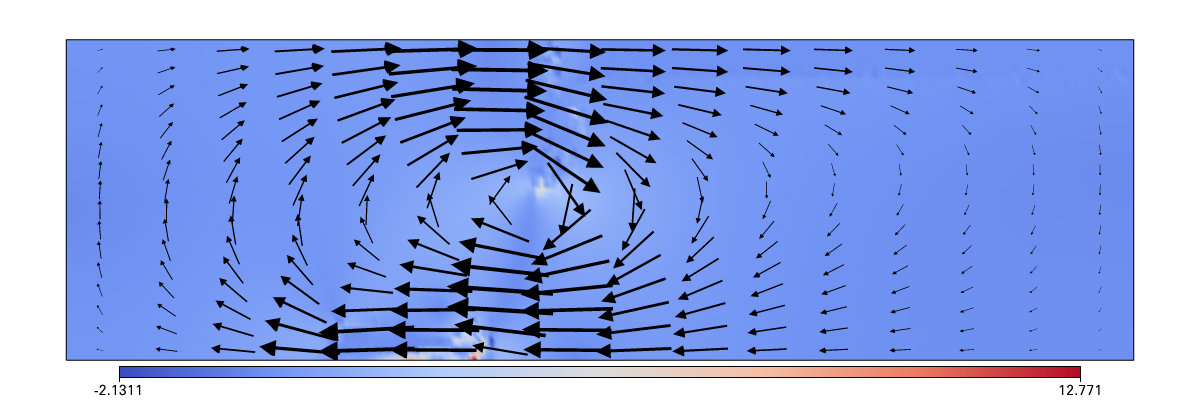

In [17]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.strainRateField, logScale=False, colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()


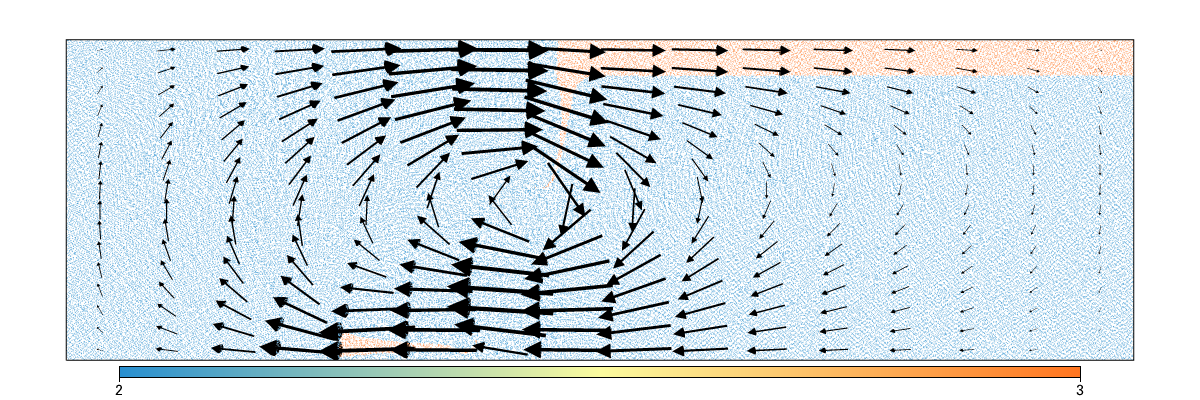

In [18]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()